### Load Data

In [254]:
## Normalize features? 
## Invert h-bond and charge? 

In [255]:
model_name = 'adl_model_siamese_baseline'
num_epochs = 10

In [256]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader #To make use of this data loader, all graph attributes in the dataset need to have the same shape. In particular, this data loader should only be used when working with dense adjacency matrices.
from torch_geometric.nn import GCNConv, dense_diff_pool, ASAPooling
from torch_geometric.utils import dense_to_sparse
import math

In [257]:
data_dir_1 = 'C:/Users/david/pyproj/pyg/adl/patch_label_1'
data_dir_0 = 'C:/Users/david/pyproj/pyg/adl/patch_label_0'
#data_dir_1 = 'adl_data_1'
#data_dir_0 = 'adl_data_0'

In [258]:
from c_PatchDataset_sparse import PatchDataset
dataset = PatchDataset(data_dir_label_0 = data_dir_0,  data_dir_label_1=data_dir_1,  neg_pos_ratio=1)
len(dataset)

572

In [259]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs pairs: {len(dataset)}')

data = dataset[0]  # Get the first graph object.
print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes in each: {data.num_nodes}')
print(f'Number of node features: {data.num_node_features}')


Dataset: PatchDataset(572):
Number of graphs pairs: 572

PairData(x=[100, 3], edge_index=[2, 602], x2=[100, 3], edge_index2=[2, 618], y=1)
Number of nodes in each: 100
Number of node features: 3


In [260]:
data.edge_index

tensor([[ 0,  0,  0,  ..., 99, 99, 99],
        [ 0, 25, 60,  ..., 95, 96, 99]])

In [261]:
# Does not work we do not have pos
#visualize_points(data.pos, data.edge_index)

In [262]:
from torch_geometric.loader import DataLoader 

batch_size = 1

n_train = math.ceil((4/6) * len(dataset))
n_val = math.ceil((len(dataset) - n_train)/2)
n_test = len(dataset) - n_train - n_val

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])
print(f'Number of training graphs pairs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_loader = DataLoader(dataset = train_dataset, batch_size= batch_size, shuffle=True)
val_loader = DataLoader(dataset = val_dataset, batch_size= batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size= batch_size, shuffle=True)

Number of training graphs pairs: 382
Number of validation graphs: 95
Number of test graphs: 95


In [263]:
len(train_loader)

382

In [264]:
databatch = next(iter(train_loader))
databatch

PairDataBatch(x=[100, 3], edge_index=[2, 632], x2=[100, 3], edge_index2=[2, 614], y=[1], batch=[100], ptr=[2])

In [265]:
# An attempt of a contrastive loss function
#   pairs with label 1 --> should get small euclid dist = small loss
#   pairs with label 0 --> should get large euclid dist = large loss

class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):

        diff = x0 - x1
        #print(f'Diff: {diff.shape}')

        pow = torch.pow(diff, 2)
        #print(f'Sq Diff: {pow.shape}')

        dist_sq = torch.sum(pow, 0)
        #print(f'Sum of Sq Diff: {dist_sq}')

        dist = torch.sqrt(dist_sq)
        #print(f'Euclidean Dist: {dist}')

        mdist = self.margin - dist #negative euclidean distance - margin = 0.3 = -2
        dist_marg = torch.clamp(mdist, min=0.0) # only distances <margin will be still positive here = 0.3 = 0
        loss =  y * torch.pow(dist, 2) + (1-y) * torch.pow(dist_marg,2)


        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        #print(f'Loss: {loss}')
        return loss

### Define Network

In [266]:
class GNN(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, pool_ratio, 
                 normalize=False, lin=False):
        super(GNN, self).__init__()

        self.conv1 = GCNConv(in_features, hidden_features, normalize)
        self.conv2 = GCNConv(hidden_features, out_features, normalize)
        self.pool = ASAPooling(out_features, ratio = pool_ratio, GNN = GCNConv)


    def forward(self, x, edge_index, mask=None):
        
        x = self.conv1(x, edge_index, mask)
        x = self.conv2(x, edge_index, mask)
        x, edge_index, _, _, _ = self.pool(x, edge_index)

        return x, edge_index


class DiffPool(torch.nn.Module):
    def __init__(self, num_nodes):
        super(DiffPool, self).__init__()

        #Hierarchical Step #1
        self.gnn1 = GNN(dataset.num_features, 8, 12, pool_ratio=0.5)

        # Hierarchical Step #2
        self.gnn2 = GNN(12, 24, 48, pool_ratio = 0.5)

        # Hierarchical Step #3
        self.gnn3 = GNN(48, 64, 96, pool_ratio = 1)

        # Final Classifier
        #self.lin1 = torch.nn.Linear(32, 64) 
        #self.lin2 = torch.nn.Linear(64, 2)



    def forward(self, x, edge_index, batch, mask=None):

        #Hierarchical Step #1
        #print(x.shape)
        x, edge_index = self.gnn1(x, edge_index, mask) # node feature embedding
        #print(x.shape)
        # Hierarchical Step #2
        x, edge_index = self.gnn2(x, edge_index)
        #print(x.shape)
        # Hierarchical Step #3
        x, edge_index = self.gnn3(x, edge_index)
        #print(x.shape)
        # Final Classification
        x = x.mean(dim=0) 
        #print(x.shape)
        
        return x #, l1 + l2 + l3, e1 + e2 + e3

In [267]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = DiffPool(num_nodes = 100).to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(epoch):
    batch = 0
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output1 = model(data.x, data.edge_index, batch)
        output2 = model(data.x2, data.edge_index2, batch = None)
        
        #Contrastive Loss
        loss_contrastive = criterion(output1,output2,data.y)
        loss_contrastive.backward()
        loss_all += data.y.size(0) * loss_contrastive.item()
        optimizer.step()
        batch +=1

    return loss_all# / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    distances_lab1 = []
    distances_lab0 = []
    loss_all = 0
    

    for data in loader:
        data = data.to(device)
        output1 = model(data.x, data.edge_index, batch=None)
        output2 = model(data.x2, data.edge_index2, batch=None)

        test_loss_contrastive = criterion(output1, output2, data.y)
        
        euclidean_distance = F.pairwise_distance(output1, output2)
        label = data.y

        if int(label) == 1: 
            distances_lab1.append(float(euclidean_distance))
            loss_all += float(test_loss_contrastive)
        else:
            distances_lab0.append(float(euclidean_distance))
            loss_all += float(test_loss_contrastive)

    return  distances_lab0, distances_lab1, loss_all



train_distances_lab0 = []
train_distances_lab1 = []
train_losses = []

validation_distances_lab0 = []
validation_distances_lab1 = []
validation_losses = []

test_distances_lab0 = []
test_distances_lab1 = []
test_losses = []

for epoch in range(1, num_epochs+1):
    
    train_loss = train(epoch)

    train_results = test(train_loader)
    train_distances_lab0.append(train_results[0])
    train_distances_lab1.append(train_results[1])
    train_losses.append(train_results[2])


    validation_results = test(val_loader)
    validation_distances_lab0.append(validation_results[0])
    validation_distances_lab1.append(validation_results[1])
    validation_losses.append(validation_results[2])

    test_results = test(test_loader)
    test_distances_lab0.append(test_results[0])
    test_distances_lab1.append(test_results[1])
    test_losses.append(test_results[2])


    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.5f}')
    #Train Acc: {train_acc:.3f}, f'Val Acc: {val_acc:.3f}, Test Acc: {test_acc:.3f}')
    


cpu
Epoch: 001, Train Loss: 0.52688
Epoch: 002, Train Loss: 0.53174
Epoch: 003, Train Loss: 0.47437
Epoch: 004, Train Loss: 0.44727
Epoch: 005, Train Loss: 0.48597
Epoch: 006, Train Loss: 0.44327
Epoch: 007, Train Loss: 0.42788
Epoch: 008, Train Loss: 0.41180
Epoch: 009, Train Loss: 0.44337
Epoch: 010, Train Loss: 0.41748


In [270]:
import numpy as np
import matplotlib.pyplot as plt

def compare_euclid_distances(distances_lab0, distances_lab1):

    w = 0.8    # bar width
    x = [1, 2] # x-coordinates of your bars
    colors = [(0, 0, 1, 1), (1, 0, 0, 1)]    # corresponding colors

    # Epoch 0
    y = [distances_lab0, distances_lab1]


    fig, ax = plt.subplots()
    ax.bar(x,
        height=[np.mean(yi) for yi in y],
        yerr=[np.std(yi) for yi in y],    # error bars
        capsize=12, # error bar cap width in points
        width=w,    # bar width
        tick_label=["Label 0", "Label 1"],
        color=(0,0,0,0),  # face color transparent
        edgecolor=colors,
        )

    for i in range(len(x)):
        # distribute scatter randomly across whole width of bar
        ax.scatter(x[i] + np.random.random(len(y[i])) * w - w / 2, y[i], color=colors[i])

    plt.ylabel = 'Euclidean Distance'
    plt.show()


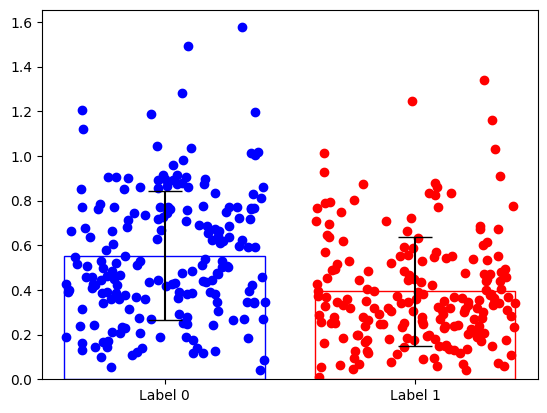

In [274]:
compare_euclid_distances(train_distances_lab0[0], train_distances_lab1[0])

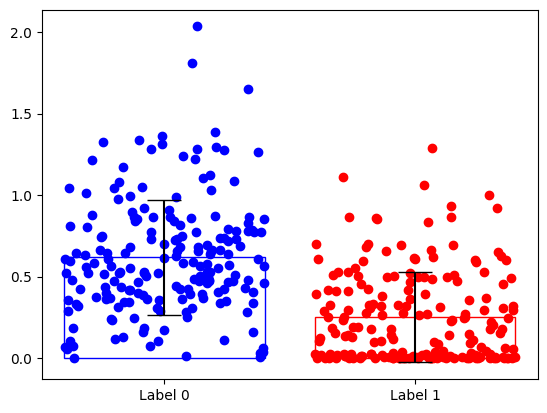

In [275]:
compare_euclid_distances(train_distances_lab0[9], train_distances_lab1[9])

TypeError: 'str' object is not callable

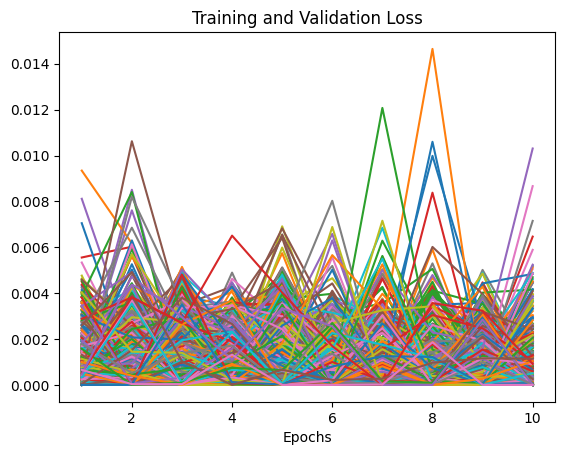

In [276]:
import matplotlib.pyplot as plt

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, num_epochs+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, num_epochs+1, num_epochs/10))
 
# Display the plot
plt.legend(loc='best')
plt.savefig(f'{model_name}_Training and Validation Loss.png')
plt.show()

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [ ]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
torch.save(model.state_dict(), f'{model_name}_state_dict.pt')

In [ ]:
torch.save(model, model_name+'.pt')

In [ ]:
train_results

In [ ]:
import numpy as np
tr_results = np.asarray(train_results)
tr_results.shape

In [ ]:
tr_results[0].shape

In [ ]:
import matplotlib.pyplot as plt
np.random.seed(123)

w = 0.8    # bar width
x = [1, 2] # x-coordinates of your bars
colors = [(0, 0, 1, 1), (1, 0, 0, 1)]    # corresponding colors
y = [np.random.random(30) * 2 + 5,       # data series
    np.random.random(10) * 3 + 8]

fig, ax = plt.subplots()
ax.bar(x,
       height=[np.mean(yi) for yi in y],
       yerr=[np.std(yi) for yi in y],    # error bars
       capsize=12, # error bar cap width in points
       width=w,    # bar width
       tick_label=["control", "test"],
       color=(0,0,0,0),  # face color transparent
       edgecolor=colors,
       #ecolor=colors,    # error bar colors; setting this raises an error for whatever reason.
       )

for i in range(len(x)):
    # distribute scatter randomly across whole width of bar
    ax.scatter(x[i] + np.random.random(y[i].size) * w - w / 2, y[i], color=colors[i])

plt.show()

In [ ]:
import numpy as np
np.save(f'{model_name}_training_loss.npy', tr_loss, allow_pickle=True)
np.save(f'{model_name}_training_accuracy.npy', tr_acc, allow_pickle=True)

np.save(f'{model_name}_validation_loss.npy', v_loss, allow_pickle=True)
np.save(f'{model_name}_validation_accuracy.npy', v_acc, allow_pickle=True)

np.save(f'{model_name}_test_loss.npy', tst_loss, allow_pickle=True)
np.save(f'{model_name}_test_accuracy.npy', tst_acc, allow_pickle=True)

In [ ]:
import numpy as np
training_loss = np.load(f'{model_name}_training_loss.npy', allow_pickle=True)
training_accuracy = np.load(f'{model_name}_training_accuracy.npy', allow_pickle=True)

validation_loss = np.load(f'{model_name}_validation_loss.npy', allow_pickle=True)
validation_accuracy = np.load(f'{model_name}_validation_accuracy.npy', allow_pickle=True)

test_loss = np.load(f'{model_name}_test_loss.npy', allow_pickle=True)
test_accuracy = np.load(f'{model_name}_test_accuracy.npy', allow_pickle=True)

In [ ]:
import matplotlib.pyplot as plt

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, num_epochs+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, num_epochs+1, num_epochs/10))
 
# Display the plot
plt.legend(loc='best')
plt.savefig(f'{model_name}_Training and Validation Loss.png')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, num_epochs+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.plot(epochs, test_accuracy, label='Test Accuracy')
 
# Add in a title and axes labels
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
 
# Set the tick locations
plt.xticks(np.arange(0, num_epochs+1, num_epochs/10))
plt.ylim(0,1)
 
# Display the plot
plt.legend(loc='best')
plt.savefig(f'{model_name}_Accuracy vs. Epochs.png')
plt.show()

In [ ]:
dataset_fraction = [0,0]

train_fraction = [0,0]
val_fraction = [0,0]
test_fraction = [0,0]

for grph in train_dataset: 
    if grph.y == 1: 
        train_fraction[1] +=1
        dataset_fraction[1] +=1 
    else: 
        train_fraction[0] +=1
        dataset_fraction[0] +=1 

for grph in val_dataset: 
    if grph.y == 1:
         val_fraction[1] +=1
         dataset_fraction[1] +=1  
    else:
         val_fraction[0] +=1
         dataset_fraction[0] +=1

for grph in test_dataset: 
    if grph.y == 1:
         test_fraction[1] +=1
         dataset_fraction[1] +=1 
    else:
         test_fraction[0] +=1
         dataset_fraction[0] +=1

print(f'Overall dataset percentage of label 1 = {dataset_fraction[1]/len(dataset)})')
print(f'Training dataset percentage of label 1 = {train_fraction} = {train_fraction[1]/len(train_dataset)}')
print(f'Validation dataset percentage of label 1 = {val_fraction} = {val_fraction[1]/len(val_dataset)}')
print(f'Test dataset percentage of label 1 = {test_fraction} = {test_fraction[1]/len(test_dataset)}')

### Input Graph: 

In [ ]:
x0, pos0, adj0 = torch.load(f'{model_name}_img0_data.pt')

In [ ]:
# Output of Embedding GNN
print(x0[0].shape)
x0[0]

In [ ]:
print(pos0[0].shape)
pos0[0]

In [ ]:
print(adj0[0].shape)
adj0[0]

In [ ]:
edge_index, _ = dense_to_sparse(adj0[0])
visualize_points(pos0[0].cpu(), edge_index)

### Graph After 1st Reduction

In [ ]:
x1_emb, x1_pool, pos1, adj1, s1= torch.load(f'{model_name}_img1_data.pt')

In [ ]:
# Output of Embedding GNN (adj0 @ x_0 @ w_gnn_emb)
print(x1_emb[0].shape)
x1_emb[0]

In [ ]:
# Output of Pooling GNN: adj_0 @ x_0 @ w_gnn_pool
print(s1[0].shape)
s1[0]

In [ ]:
# Output Coordinate Matrix (pos_out = softmax(s).t() @ pos_in)
print(pos1[0].shape)
pos1[0]

In [ ]:
# Output Feature Matrix (x_out = softmax(s).t() @ x_in)
print(x1_pool[0].shape)
x1_pool[0]

In [ ]:
# Output Adjacency Matrix = softmax(adj_out = softmax(s.t()) @ adj_in @ softmax(s))
print(adj1[0].shape)
adj1[0]

In [ ]:
edge_index, _ = dense_to_sparse(adj1[0])
visualize_points(pos1[0].cpu(), edge_index)

### Graph after 2nd reduction

In [ ]:
x2_emb, x2_pool, pos2, adj2, s2 = torch.load(f'{model_name}_img2_data.pt')

In [ ]:
# Output of Embedding GNN (adj1 @ x1_pool @ w_gnn_emb)
print(x2_emb[0].shape)
x2_emb[0]

In [ ]:
# Output of Pooling GNN: adj1 @ x1_pool @ w_gnn_pool), dim=1
print(s2[0].shape)
s2[0]

In [ ]:
# Output Coordinate Matrix (pos_out = softmax(s.t()) @ pos_in)
print(pos2[0].shape)
pos2[0]

In [ ]:
# Output Feature Matrix (x_out = softmax(s2).t() @ x2_emb)
print(x2_pool[0].shape)
x2_pool[0]

In [ ]:
# Output Adjacency Matrix (adj = softmax(s).T @ adj @ softmax(s)
print(adj2[0].shape)
adj2[0]

In [ ]:
edge_index, _ = dense_to_sparse(adj2[0])
visualize_points(pos2[0].cpu(), edge_index)

### Graph after 3rd reduction

In [ ]:
x3_emb, x3_pool, pos3, adj3, s3 = torch.load(f'{model_name}_img3_data.pt')

In [ ]:
# Output of Embedding GNN (adj_0 @ x_0 @ w_gnn_emb)
print(x3_emb[0].shape)
x3_emb[0]

In [ ]:
# Output of Pooling GNN: torch.softmax(adj_0 @ x_0 @ w_gnn_pool), dim=1)
print(s3[0].shape)
s3[0]

In [ ]:
# Output Coordinate Matrix (pos_out = softmax(s.t()) @ pos_in)
print(pos3[0].shape)
pos3[0]

In [ ]:
# Output Feature Matrix (x_out = softmax(s.t()) @ x_0)
print(x3_pool[0].shape)
x3_pool[0]

In [ ]:
# Output Adjacency Matrix (adj = softmax(s.t()) @ adj @ softmax(s)
print(adj3[0].shape)
adj3[0]

In [ ]:
edge_index, _ = dense_to_sparse(adj3[0])
visualize_points(pos3[0].cpu(), edge_index)